In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/project

/gdrive/MyDrive/project


In [3]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 5.9MB/s 


In [85]:
import random
import os
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import F1Score


## 시드값 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything()

### 전처리 데이터 불러오기

In [5]:
df = pd.read_csv('df.csv', index_col=0)
df.head()

,Text,Score
0,think ruin dish open pour past stick lid thin...,0
1,product nothing marvel false advertisement wa...,0
2,animal digest already lol yeard old miniature...,0
3,hey big actually two candy bar wrap serve two...,1
4,olive oil mean much oil mayo olive oil much o...,0


### 정수 인코딩

In [6]:
tokenizer = Tokenizer()

#fit_on_texts: 빈도수가 높은 순으로 낮은 정수 인덱스 부여
tokenizer.fit_on_texts(df['Text'])
tokenized = tokenizer.texts_to_sequences(df['Text']) 

In [7]:
# 총 단어 수
vocab_size = len(tokenizer.word_index) + 1

#### max_len을 직접 설정하기 위해 문장의 길이를 그래프로 그려본다

In [8]:
from collections import Counter

In [9]:
sent_len = [len(item) for item in tokenized]
cnt_sent_len = Counter(sent_len)

No handles with labels found to put in legend.


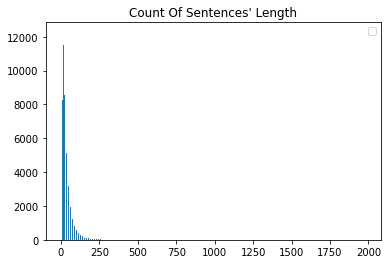

In [10]:
plt.bar(list(cnt_sent_len.keys()), list(cnt_sent_len.values()))
plt.title('Count Of Sentences\' Length')
plt.legend()      

plt.show()

No handles with labels found to put in legend.


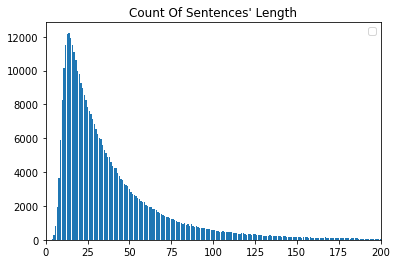

In [11]:
plt.bar(list(cnt_sent_len.keys()), list(cnt_sent_len.values()))
plt.xlim((0, 200))
plt.title('Count Of Sentences\' Length')
plt.legend()      

plt.show()

In [12]:
less = 0
for length, count in cnt_sent_len.items():
  if length <= 150: 
    less = less + count

round(less/sum(list(cnt_sent_len.values())),2)

0.98

98퍼센트의 문장의 길이가 150이하 이므로 max_len = 150으로 한다.

In [13]:
max_len = 150

In [14]:
# 결과 확인
for i in range(5):
    print(tokenized[i],"\n")

[30, 1544, 378, 130, 513, 474, 224, 988, 30, 1, 586, 106, 167, 542, 3259, 561, 31, 1, 25, 474, 534, 3, 1354, 3127, 2, 264, 275, 1, 14, 80] 

[15, 243, 8274, 2890, 4503, 464, 242, 52, 137, 1193, 372, 3119, 382, 20279, 2783, 804, 17232, 20, 1333, 39, 1064, 8274, 20280, 798, 52458, 372, 576] 

[1316, 1593, 470, 1176, 52459, 126, 3312, 5784, 2164, 22, 66, 37, 269, 23, 160, 99, 405, 76, 1119, 34, 162, 1, 24178, 463, 114, 1322, 182, 19343, 18544, 28, 92, 378, 33, 62, 307, 916, 264, 156, 15, 284, 264, 165, 284, 120, 339, 358, 421, 11057, 1400, 44, 4068, 148, 358, 421, 407, 358, 46, 5200, 9926, 3843, 47, 1316, 1593, 127, 8275, 688, 1536, 3153, 14254, 3843, 9927, 688, 1983, 7920, 14573, 100, 1239, 100, 1470, 1404, 1292, 1404, 11830, 5741, 3153, 612, 850, 740, 578, 37, 269, 8911, 10047, 3260, 3022, 20281, 16160, 8154, 3022, 3806, 5413, 3022, 1404, 7207, 4440, 850, 6695, 5472, 5982, 618, 93, 618, 93, 30, 618, 122, 34, 17834, 39119, 3830, 3022] 

[1749, 146, 149, 67, 131, 78, 537, 134, 67, 157, 68

### padding

In [15]:
x = pad_sequences(tokenized, maxlen=max_len)

# 결과확인
for i in range(5):
    print(x[i])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   30 1544  378  130  513  474
  224  988   30    1  586  106  167  542 3259  561   31    1   25  474
  534    3 1354 3127    2  264  275    1   14   80]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0 

In [16]:
y = df['Score']

### 데이터 정보 확인

In [17]:
print("x.shape = ", x.shape)
print("y.shape = ", y.shape)

x.shape =  (393577, 150)
y.shape =  (393577,)


In [18]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 86820, 1: 306757}

Text(0.5, 1.0, 'Bar plot of Score')

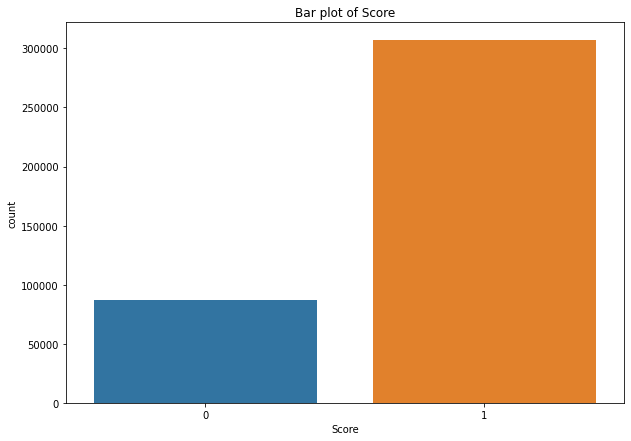

In [19]:
plt.figure(figsize = (10,7))
sns.countplot(x = df['Score'])
plt.title("Bar plot of Score")

## FastText

In [20]:
from gensim.models import KeyedVectors
FASTTEXTFILE="crawl-300d-2M.vec"
FastText=KeyedVectors.load_word2vec_format(FASTTEXTFILE)

In [21]:
embedding_matrix = np.zeros((vocab_size, 300))

In [22]:
for word, i in tokenizer.word_index.items():   # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    if word in FastText:                       # FastText에 단어가 존재하면
        embedding_matrix[i] = FastText.get_vector(word)             # 해당 단어 위치의 행에 벡터의 값을 저장한다.

In [23]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0538    , -0.1575    , -0.037     , ..., -0.63129997,
         0.14399999,  0.0629    ],
       [-0.12899999, -0.36520001,  0.12549999, ..., -0.2211    ,
        -0.26589999, -0.1293    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33649999, -0.1159    ,  0.46810001, ...,  0.2518    ,
         0.29809999,  0.37099999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [24]:
embedding_matrix.shape

(114026, 300)

In [25]:
zerovec = np.sum(np.sum(embedding_matrix, axis=1) == 0) # 모두 0으로 이루어진 벡터 (FastText voca에 없는 단어)
zerovec

48189

In [26]:
round(zerovec/embedding_matrix.shape[0],2)

0.42

### 모델 생성

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)
print("x_train.shape : ", x_train.shape)
print("x_val.shape : ", x_val.shape)
print("x_test.shape  : ", x_test.shape)

x_train.shape :  (251888, 150)
x_val.shape :  (62973, 150)
x_test.shape  :  (78716, 150)


In [87]:
f1score = F1Score(num_classes=1, threshold=0.5)
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

In [88]:
def create_model():
    model = Sequential()
    
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))

    model.add(LSTM(128))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=adam, metrics=['accuracy', f1score], loss='binary_crossentropy')
    
    return model

In [89]:
model = create_model()

In [90]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 300)          34207800  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 34,427,577
Trainable params: 219,777
Non-trainable params: 34,207,800
_________________________________________________________________


In [91]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [92]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)

In [93]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), callbacks = [reduce_lr, es], epochs=100, batch_size=512)

Epoch 1/100
492/492 [==============================] - 1013s 2s/step - loss: 0.3360 - accuracy: 0.8506 - f1_score: 0.9070 - val_loss: 0.2446 - val_accuracy: 0.8988 - val_f1_score: 0.9372
Epoch 2/100
492/492 [==============================] - 1012s 2s/step - loss: 0.2264 - accuracy: 0.9075 - f1_score: 0.9414 - val_loss: 0.2246 - val_accuracy: 0.9085 - val_f1_score: 0.9416
Epoch 3/100
492/492 [==============================] - 1016s 2s/step - loss: 0.2099 - accuracy: 0.9146 - f1_score: 0.9459 - val_loss: 0.2225 - val_accuracy: 0.9097 - val_f1_score: 0.9429
Epoch 4/100
492/492 [==============================] - 1039s 2s/step - loss: 0.1845 - accuracy: 0.9266 - f1_score: 0.9533 - val_loss: 0.2255 - val_accuracy: 0.9102 - val_f1_score: 0.9432

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 5/100
492/492 [==============================] - 1021s 2s/step - loss: 0.1500 - accuracy: 0.9416 - f1_score: 0.9629 - val_loss: 0.2351 - val_accuracy: 0.9097 - val_f

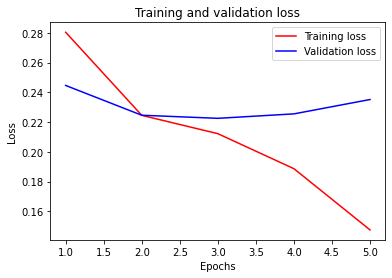

In [97]:
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'r', label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()      

plt.show()

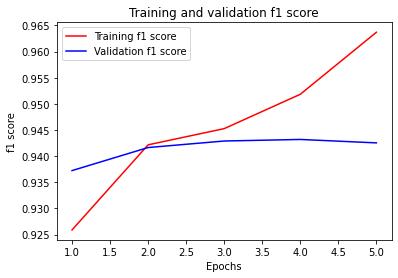

In [98]:
plt.plot(epochs, history.history['f1_score'], 'r', label = 'Training f1 score')
plt.plot(epochs, history.history['val_f1_score'], 'b', label = 'Validation f1 score')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('f1 score')
plt.legend()      

plt.show()

### prediction

In [96]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=512)

154/154 [==============================] - 122s 790ms/step - loss: 0.2386 - accuracy: 0.9078 - f1_score: 0.9413
